In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Carregar os dados de um diretório
directory = "C:/Users/Lucas Teixeira/AP-Emulators/Generated_Data_100K/ModelA"  # Substitua pelo seu diretório
Ns = 2048  # Número máximo de amostras a carregar
X = pd.read_csv(os.path.join(directory, "X.csv")).iloc[0:Ns]
Y = pd.read_csv(os.path.join(directory, "Y.csv")).iloc[0:Ns]
print(f"Carregado X com forma: {X.shape}")
print(f"Carregado Y com forma: {Y.shape}")

# Dividir os dados em treino e validação
test_size = 0.5
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
print(f"Treino X: {X_train.shape}, Validação X: {X_val.shape}")
print(f"Treino Y: {Y_train.shape}, Validação Y: {Y_val.shape}")

Carregado X com forma: (2048, 3)
Carregado Y com forma: (2048, 5)
Treino X: (1024, 3), Validação X: (1024, 3)
Treino Y: (1024, 5), Validação Y: (1024, 5)


In [3]:
# Verificar se todas as variáveis são DataFrames
if isinstance(X_train, pd.DataFrame) and isinstance(X_val, pd.DataFrame) and isinstance(Y_train, pd.DataFrame) and isinstance(Y_val, pd.DataFrame):
    X_train = torch.tensor(X_train.values, dtype=torch.float32).contiguous()
    X_val = torch.tensor(X_val.values, dtype=torch.float32).contiguous()
    Y_train = torch.tensor(Y_train.values, dtype=torch.float32).contiguous()
    Y_val = torch.tensor(Y_val.values, dtype=torch.float32).contiguous()

In [4]:
if torch.cuda.is_available():
    X_train, Y_train, X_val, Y_val = X_train.cuda(), Y_train.cuda(), X_val.cuda(), Y_val.cuda()

In [5]:
from gpytorch.models import ApproximateGP
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood, k=256, training_batch_size=256):

        m, d = inducing_points.shape
        self.m = m
        self.k = k

        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(m)

        if torch.cuda.is_available():
            inducing_points = inducing_points.cuda()

        variational_strategy = NNVariationalStrategy(self, inducing_points, variational_distribution, k=k,
                                                     training_batch_size=training_batch_size)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d)

        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, prior=False, **kwargs):
        if x is not None:
            if x.dim() == 1:
                x = x.unsqueeze(-1)
        return self.variational_strategy(x=x, prior=False, **kwargs)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Note: one should use full training set as inducing points!
model = GPModel(inducing_points=X_train, likelihood=likelihood, k=32, training_batch_size=32)

if torch.cuda.is_available():
    likelihood = likelihood.cuda()
    model = model.cuda()

In [8]:
from torch.utils.data import TensorDataset, DataLoader

# prepare for dataset
train_dataset = TensorDataset(X_train, Y_train)
# this batch-size does not need to match the training-batch-size specified above
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

num_epochs = 10


model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Y_train.size(0))


epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch: 100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


In [12]:
# prepare for dataset
test_dataset = TensorDataset(X_val, Y_val)
# this batch-size does not need to match the training-batch-size specified above
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model.eval()
likelihood.eval()
means = torch.tensor([0.])
test_mse = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])

        diff = torch.pow(preds.mean - y_batch, 2)
        diff = diff.sum(dim=-1) / X_val.size(0) # sum over bsz and scaling
        diff = diff.mean() # average over likelihood_nsamples
        test_mse += diff
means = means[1:]
test_rmse = test_mse.sqrt().item()

IndexError: too many indices for tensor of dimension 1

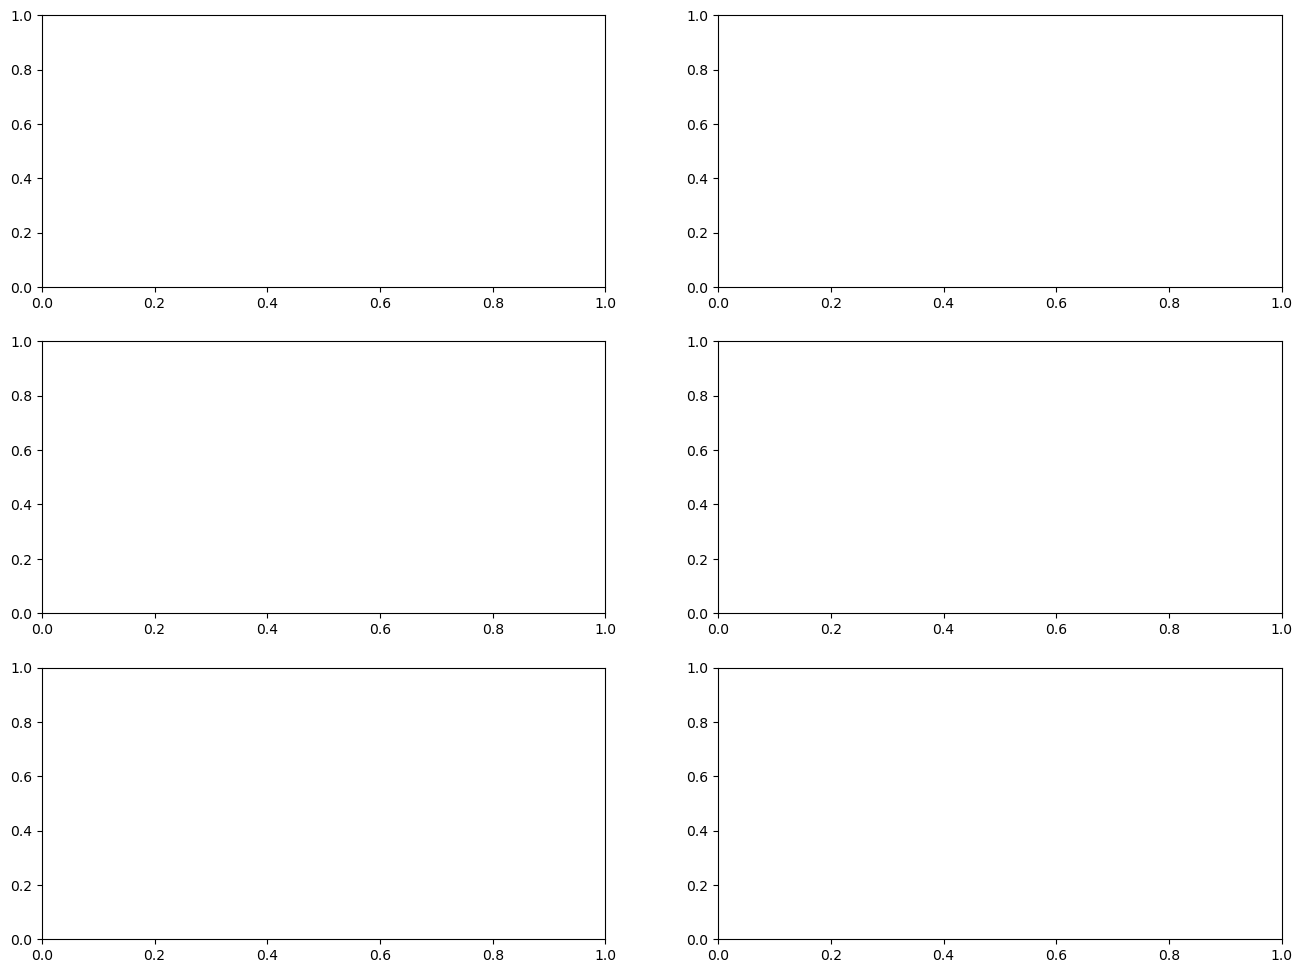

In [22]:
# Plotar Y verdadeiro vs Y previsto para cada QoI
# Configurar layout do mega plot
means = means.cpu()
Y_val = Y_val.cpu()

num_qois = len(Y.columns)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, qoi in enumerate(Y.columns):
    ax = axes[i]
    ax.scatter(Y_val[:, i].numpy(), means[:, Y.columns.get_loc(qoi)], alpha=0.6, label="Previsões")
    ax.plot([Y_val[:, i].numpy().min(), Y_val[:, i].numpy().max()], [Y_val[:, i].numpy().min(), Y_val[:, i].numpy().max()], 
            color="red", linestyle="--", label="Ideal")
    r2 = r2_score(Y_val[:, i].numpy(), means[:, Y.columns.get_loc(qoi)])
    ax.set_title(f"{qoi}: Y Verdadeiro vs Y Previsto - R² = {round(r2,4)}")
    ax.set_xlabel("Y Verdadeiro")
    ax.set_ylabel("Y Previsto")
    ax.legend()
    ax.grid(True)

# Desativar eixos vazios, caso o número de QoIs seja menor que o total de subplots
for j in range(len(axes)):
    if j >= num_qois:
        axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f"{name}.jpg")

# Primeiro modo

In [ ]:
num_epochs = 1000
num_batches = model.variational_strategy._total_training_batches


model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Y_train.size(0))


epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for epoch in epochs_iter:
    minibatch_iter = tqdm(range(num_batches), desc="Minibatch", leave=False)

    for i in minibatch_iter:
        optimizer.zero_grad()
        output = model(x=None)
        # Obtain the indices for mini-batch data
        current_training_indices = model.variational_strategy.current_training_indices
        # Obtain the y_batch using indices. It is important to keep the same order of train_x and train_y
        y_batch = Y_train[...,current_training_indices]
        if torch.cuda.is_available():
            y_batch = y_batch.cuda()
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


test_dataset = TensorDataset(X_val, Y_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
test_mse = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])

        diff = torch.pow(preds.mean - y_batch, 2)
        diff = diff.sum(dim=-1) / X_val.size(0) # sum over bsz and scaling
        diff = diff.mean() # average over likelihood_nsamples
        test_mse += diff
means = means[1:]
test_rmse = test_mse.sqrt().item()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


test_dataset = TensorDataset(X_val, Y_val)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
test_mse = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])

        diff = torch.pow(preds.mean - y_batch, 2)
        diff = diff.sum(dim=-1) / X_val.size(0) # sum over bsz and scaling
        diff = diff.mean() # average over likelihood_nsamples
        test_mse += diff
means = means[1:]
test_rmse = test_mse.sqrt().item()
print(test_rmse)

In [ ]:
Y_val = Y_val.cpu()

# Set into eval mode
model.eval()
likelihood.eval()

# # Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_val))
    mean = predictions.mean.cpu()
    lower, upper = predictions.confidence_region()

In [ ]:
Y_val = Y_val.cpu()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_val_tensor))
    mean = predictions.mean.cpu()
    lower, upper = predictions.confidence_region()

In [ ]:
# Plotar Y verdadeiro vs Y previsto para cada QoI
# Configurar layout do mega plot

num_qois = len(Y.columns)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, qoi in enumerate(Y.columns):
    ax = axes[i]
    ax.scatter(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)], alpha=0.6, label="Previsões")
    ax.plot([Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], [Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], 
            color="red", linestyle="--", label="Ideal")
    r2 = r2_score(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)])
    ax.set_title(f"{qoi}: Y Verdadeiro vs Y Previsto - R² = {round(r2,4)}")
    ax.set_xlabel("Y Verdadeiro")
    ax.set_ylabel("Y Previsto")
    ax.legend()
    ax.grid(True)

# Desativar eixos vazios, caso o número de QoIs seja menor que o total de subplots
for j in range(len(axes)):
    if j >= num_qois:
        axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f"{name}.jpg")